# **Análisis espectral**
## Procesamiento de Imagen y Señal
### **Alan García Justel**
### Curso 2024-2025

In [3]:
import os
import sys

import math
import cmath

##

import warnings
warnings.filterwarnings('ignore')

##

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib.colors import LogNorm
from matplotlib import pyplot
import matplotlib.image as im

from scipy import signal, fftpack, interpolate
from scipy.fft import fft, ifft
from scipy.signal import chirp, spectrogram, get_window
import scipy.signal.windows as windows

from skimage import io

import IPython.display as ipd
import librosa
import librosa.display

import soundfile as sf

from pydub import AudioSegment

#### Important tips
# To hear the signal
# ipd.Audio(x, rate=fs)
####

from operator import itemgetter
import cv2

In [2]:
def audio_player_list(signals, rates, width=270, height=40, columns=None, column_align='center'):
    """Generate a list of HTML audio players tags for a given list of audio signals.

    Notebook: B/B_PythonAudio.ipynb

    Args:
        signals (list): List of audio signals
        rates (list): List of sample rates
        width (int): Width of player (either number or list) (Default value = 270)
        height (int): Height of player (either number or list) (Default value = 40)
        columns (list): Column headings (Default value = None)
        column_align (str): Left, center, right (Default value = 'center')
    """
    pd.set_option('display.max_colwidth', None)

    if isinstance(width, int):
        width = [width] * len(signals)
    if isinstance(height, int):
        height = [height] * len(signals)

    audio_list = []
    for cur_x, cur_Fs, cur_width, cur_height in zip(signals, rates, width, height):
        audio_html = ipd.Audio(data=cur_x, rate=cur_Fs)._repr_html_()
        audio_html = audio_html.replace('\n', '').strip()
        audio_html = audio_html.replace('<audio ', f'<audio style="width: {cur_width}px; height: {cur_height}px" ')
        audio_list.append([audio_html])

    df = pd.DataFrame(audio_list, index=columns).T
    table_html = df.to_html(escape=False, index=False, header=bool(columns))
    table_html = table_html.replace('<th>', f'<th style="text-align: {column_align}">')
    ipd.display(ipd.HTML(table_html))

---

# **Espectro de una señal**

1. ***Espectro de una sinusoide compuesta por dos sinusoides simples*** 

   Genera una sinusoide compuesta con $t \in [-2\pi,2\pi]$. 

   $$x(t) = 0.5 \cdot sin(3t)+0.25 \cdot sin(10t)$$

   Calcula su espectro así como la magnitud del mismo en decibelios tanto para la sinusoide compuesta como para las partes simples. Visualiza también la suma de las magnitudes del espectro de cada parte de la sinusoide.

   Utiliza una frecuencia de muestreo de $800$ Hz.

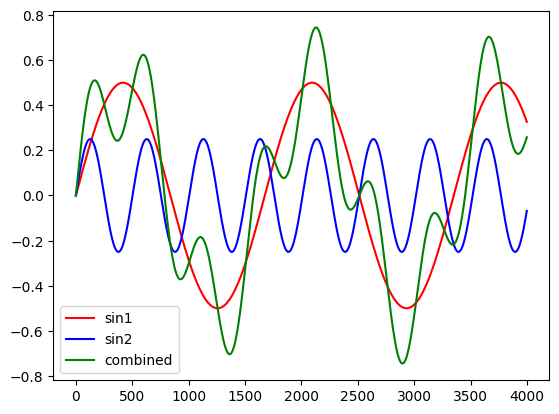

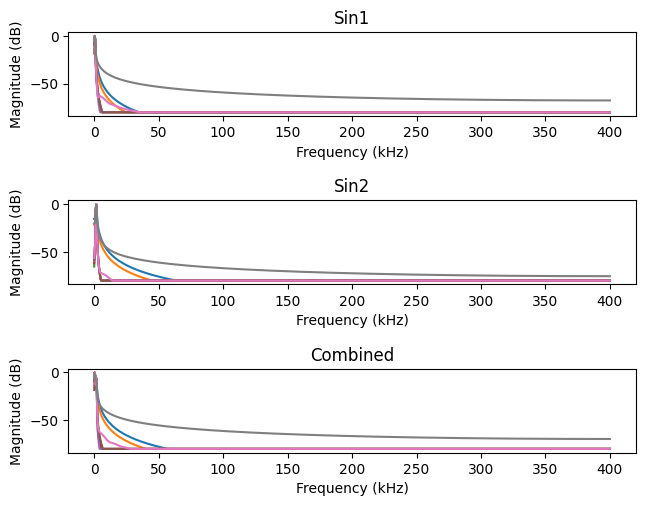

In [3]:
# Generar dos funciones sinusoidales sencillas (por partes)
duracion    = 5         # Duración (en s) de la señal generada
fs          = 800       # Frecuencia de muestreo en Hz
t = np.linspace(0, duracion, int(fs * duracion), endpoint=False)

sin1 = 0.5  * np.sin(3 * t)
sin2 = 0.25 * np.sin(10 * t)

# Combinación de las dos funciones
x = sin1 + sin2

# Transformada de Fourier de las funciones y de la función combinada. 
sin1_fft    = librosa.stft(sin1)
sin2_fft    = librosa.stft(sin2)
x_fft       = librosa.stft(x)

def plot_signal_spectrums(signal_ffts, sampling_rates, labels):
    """
    Plotea el espectro de una señal dada la señal y su frecuencia de muestreo.
    
    Parameters:
        signal (numpy array): La señal en el dominio del tiempo.
        sampling_rate (float): Frecuencia de muestreo en Hz.
    """
    f, axs = plt.subplots(len(signal_ffts))
    f.tight_layout()
    for ax, fft_values, fs, label in zip(axs, signal_ffts, sampling_rates, labels):
        f = np.linspace(0, fs/2, num=len(fft_values))
        D = librosa.amplitude_to_db(np.abs(fft_values), ref=np.max)
        ax.plot(f, D)
        ax.set_title(label)
        ax.set_xlabel('Frequency (kHz)')
        ax.set_ylabel('Magnitude (dB)')
    plt.subplots_adjust(hspace=1.0) 

# Visualización
plt.plot(sin1, color = "red",   label = "sin1")
plt.plot(sin2, color = "blue",  label = "sin2")
plt.plot(x, color = "green",    label = "combined")
plt.legend()
plt.show()

# Magnitud y magnitud en decibelios
plot_signal_spectrums( [sin1_fft, sin2_fft, x_fft], [fs, fs, fs], ["Sin1", "Sin2", "Combined"])



<hr style="border: 1px solid green" />


2. Visualiza algunas muestras de la señal de audio, su espectro y su espectrograma:
    1. seno (`audio/sinewave.wav`)
    2. sirena (`audio/sirena.wav`)

Oye la señal pero con cuidado ya que puede ser un sonido muy agudo.

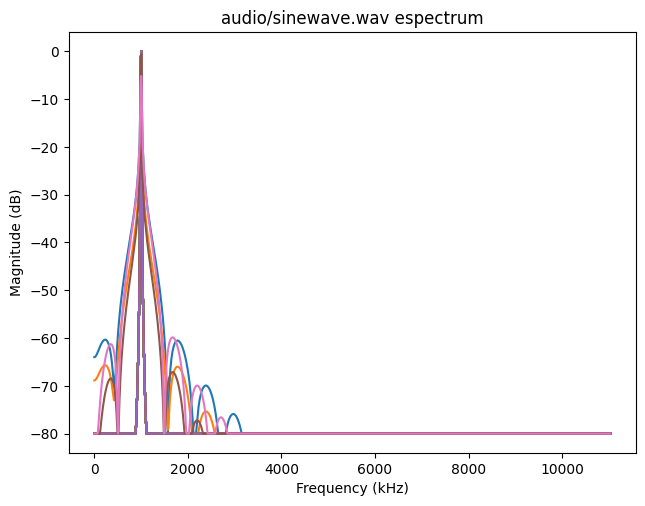

In [10]:
audio_path = "audio/sinewave.wav"
audio, fs = librosa.load(audio_path)

# Espectro
def plot_signal_spectrums(ax, audio, fs, label):
    signal_fft = librosa.stft(audio)
    f = np.linspace(0, fs/2, num=len(signal_fft))
    D = librosa.amplitude_to_db(np.abs(signal_fft), ref=np.max)
    ax.plot(f, D)
    ax.set_title(label)
    ax.set_xlabel('Frequency (kHz)')
    ax.set_ylabel('Magnitude (dB)')

f, ax = plt.subplots(1)
f.tight_layout()
plot_signal_spectrums(ax, audio, fs, f"{audio_path} espectrum")
plt.subplots_adjust(hspace=1.0) 

ipd.Audio(audio, rate=fs)


<hr style="border: 1px solid green" />

3. ***Espectro de una sinusoide con relleno (*Zero-padding*)*** 

    Genera una sinusoide compuesta rellenada con ceros al final de la señal. Visualiza la señal, la señal rellenada, el espectro de la señal original y el espectro de la señal rellenada.

    $$x(t) = cos(2 \pi f_{1} t) + sin(2 \pi f_{2} t)$$

    donde la frecuencia de muestreo es de $1000$ Hz, la duración de la señal es de $256$ muestras y las frecuencias son: $f_{1}=50$ y $f_{2}=101.5$

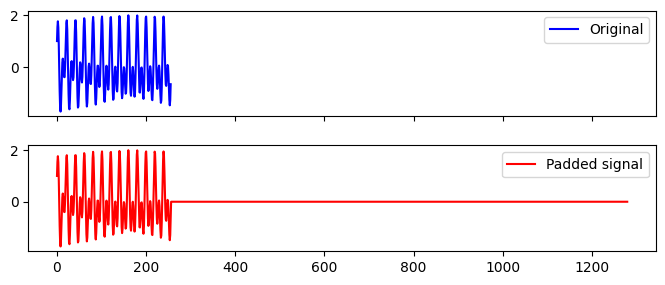

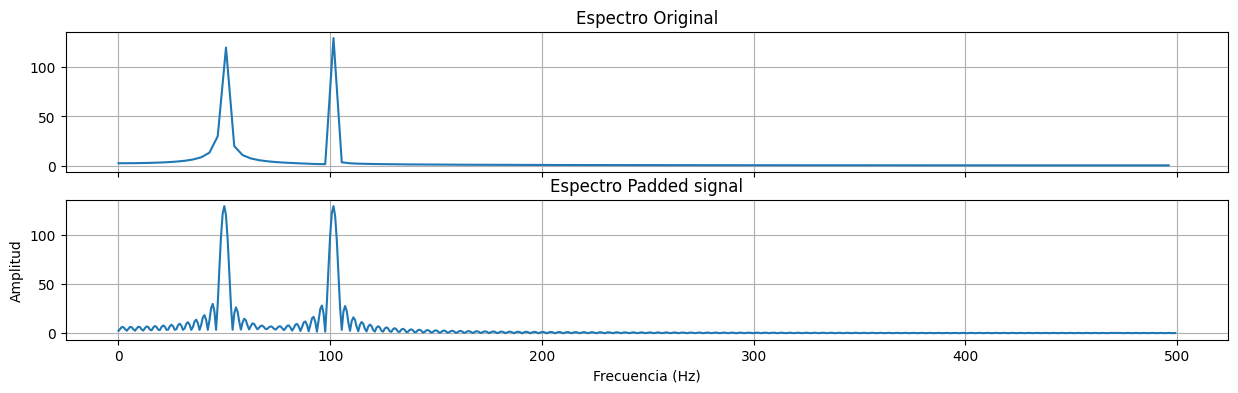

In [24]:
num_samples = 256       # numero de muestras de la señal generada
fs          = 1000      # Frecuencia de muestreo en Hz
f1 = 50
f2 = 101.5
t = np.linspace(0, num_samples / fs, num_samples, endpoint=False)

# Función sinusoidal compuesta
signal = np.cos(2*np.pi*f1*t) + np.sin(2*np.pi*f2*t)

# Zero-padding (1024 muestras)
signal_padding = np.pad(signal, (0, 1024))

# Visualización
f, axs = plt.subplots(2, figsize=(7, 3), sharex=True)
plt.tight_layout()
axs[0].plot(signal, color = "blue",   label = "Original")
axs[0].legend()
axs[1].plot(signal_padding, color = "red",   label = "Padded signal")
axs[1].legend()

# Espectro
def plot_spectrum(ax, signal, fs, title):
    n = len(signal)
    fft_result = np.fft.fft(signal)
    freqs = np.fft.fftfreq(n, 1 / fs)
    amplitude = np.abs(fft_result)
    half_n = n // 2
    freqs = freqs[:half_n]
    amplitude = amplitude[:half_n]
    ax.plot(freqs, amplitude)
    ax.set_title(title)
    ax.grid()

signals = [(signal, "Espectro Original"), (signal_padding, "Espectro Padded signal")]
f, axs = plt.subplots(2, figsize=(15, 4), sharex=True)
for i, (a, label) in enumerate(signals):
    plot_spectrum(axs[i], a, fs, label)
axs[i].set_xlabel('Frecuencia (Hz)')
axs[i].set_ylabel('Amplitud')
plt.show()


<hr style="border: 1px solid green" />

4. **Espectro de una sinusoide no tan simple**

    Genera una sinusoide:

    $$x(t)=A \cos(2 \pi f \cdot t + \phi)$$

    donde : 
    * Duración: $N = 64$
    * Amplitud y fase de la sinusoide: $A=1$ y $\phi=0$
    * Frecuencia base ($f_{base}$) : Elige la frecuencia base que desees $\in [0, 1]$
    * Frecuencia de muestreo variable: $f = f_{base} + \frac{1}{2N}$ ciclos/muestra

    Calcula su espectro y la magnitud del espectro en decibelios. Realiza el mismo estudio con la sinusoide rellenada con ceros al final de la señal (*zero padding*) con factor de relleno = $8$.

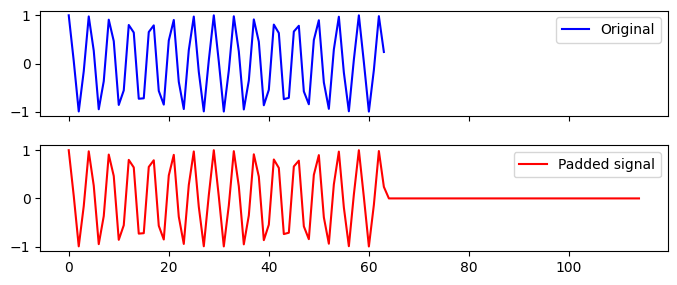

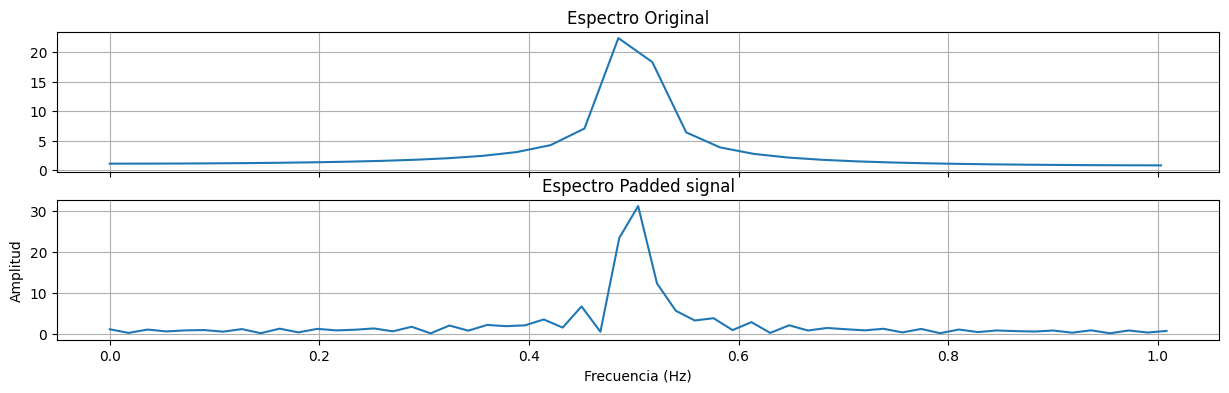

In [29]:
num_samples = 64        # numero de muestras de la señal generada
f_base      = 0.5       # Frecuencia base
fs          = f_base + 1 / 2*np.pi  # Frecuencia de muestreo en Hz
A           = 1         # Amplitud
phase       = 0         # Fase
t = np.linspace(0, num_samples / fs, num_samples, endpoint=False)

# Función sinusoidal base
x = A * np.cos(2*np.pi * f_base * t + phase)
x_padded = np.pad(x, (0, int(num_samples * 0.8)))

# Visualizar
f, axs = plt.subplots(2, figsize=(7, 3), sharex=True)
plt.tight_layout()
axs[0].plot(x, color = "blue",   label = "Original")
axs[0].legend()
axs[1].plot(x_padded, color = "red",   label = "Padded signal")
axs[1].legend()

# Espectro
def plot_spectrum(ax, signal, fs, title):
    n = len(signal)
    fft_result = np.fft.fft(signal)
    freqs = np.fft.fftfreq(n, 1 / fs)
    amplitude = np.abs(fft_result)
    half_n = n // 2
    freqs = freqs[:half_n]
    amplitude = amplitude[:half_n]
    ax.plot(freqs, amplitude)
    ax.set_title(title)
    ax.grid()

signals = [(x, "Espectro Original"), (x_padded, "Espectro Padded signal")]
f, axs = plt.subplots(2, figsize=(15, 4), sharex=True)
for i, (a, label) in enumerate(signals):
    plot_spectrum(axs[i], a, fs, label)
axs[i].set_xlabel('Frecuencia (Hz)')
axs[i].set_ylabel('Amplitud')
plt.show()

<hr style="border: 1px solid green" />

5. **Espectros de señales sinusoidales**

    Genera dos señales sinusoidales con frecuencia de muestreo de 8000Hz con una duración de 2 segundos. Obtén los espectros de ambas señales.

    $$s_{1} = \frac{1}{6} \sin(880 \pi \cdot t) + \frac{1}{15} \sin(1760\pi \cdot t)$$

    $$s_{2} = \frac{1}{6} \sin(16880\pi \cdot t) - \frac{1}{15} \sin(14240 \pi \cdot t)$$

    ¿ Qué puedes decir sobre ambas señales una vez vistos sus espectros ? **ESCRIBE AQUÍ TU RESPUESTA**

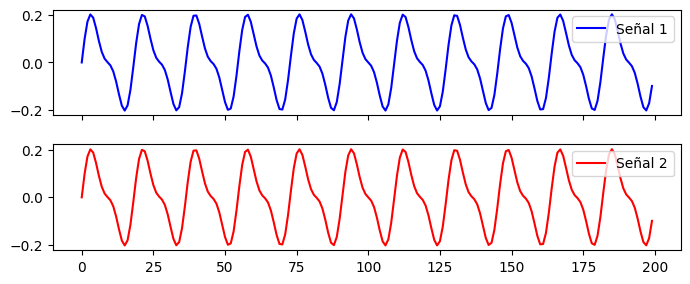

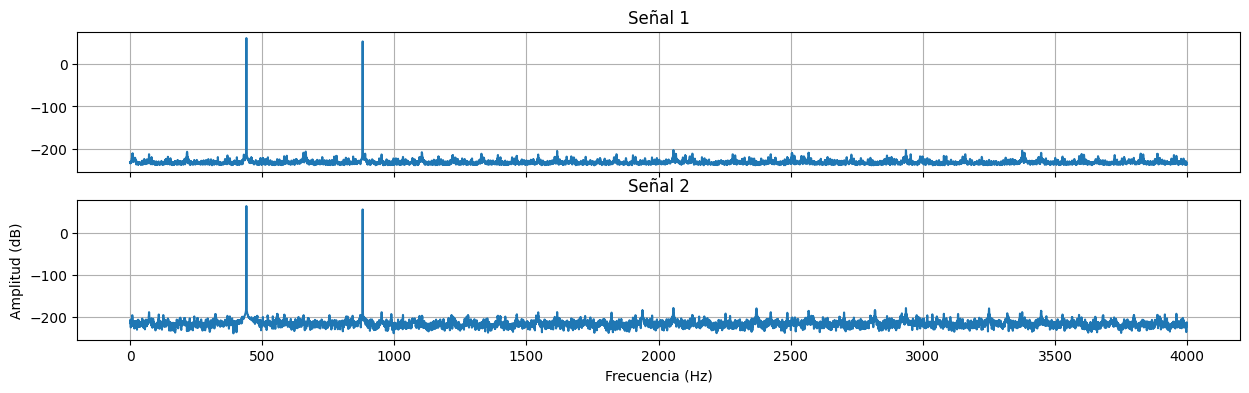

In [6]:
duracion = 2    # Duración (en s) de la señal
fs = 8000       # Frecuencia de muestreo (en Hz)
t = np.linspace(0, duracion, int(duracion * fs), endpoint=False)

s1 = 1/6 * np.sin(880*np.pi*t) + 1/15 * np.sin(1760*np.pi*t)
s2 = 1/6 * np.sin(16880*np.pi*t) - 1/15 * np.sin(14240*np.pi*t)

# Visualizar las señales
f, axs = plt.subplots(2, figsize=(7, 3), sharex=True)
plt.tight_layout()
axs[0].plot(s1[:200], color = "blue",   label = "Señal 1")
axs[0].legend()
axs[1].plot(s2[:200], color = "red",   label = "Señal 2")
axs[1].legend()

# Espectro de las señales
def plot_spectrum(ax, signal, fs, title):
    n = len(signal)
    fft_result = np.fft.fft(signal)
    freqs = np.fft.fftfreq(n, 1 / fs)

    amplitude = np.abs(fft_result)
    amplitude = 20 * np.log10(amplitude + 1e-12) # Convert amplitude to decibels

    half_n = n // 2
    freqs = freqs[:half_n]
    amplitude = amplitude[:half_n]
    ax.plot(freqs, amplitude)
    ax.set_title(title)
    ax.grid()

signals = [(s1, "Señal 1"), (s2, "Señal 2")]
f, axs = plt.subplots(2, figsize=(15, 4), sharex=True)
for i, (a, label) in enumerate(signals):
    plot_spectrum(axs[i], a, fs, label)
axs[i].set_xlabel('Frecuencia (Hz)')
axs[i].set_ylabel('Amplitud (dB)')
plt.show()

---

# **Espectro de una señal con ruido**

6. **Espectro de una señal contaminada con ruido**
  
    Mediante la transformada de Fourier encuentra los componentes frecuenciales de una señal contaminada con ruido blanco, $ruido_t ~\sim N(0,\sigma^2)=N(0, 4)$.

    $$x(t)=0.7sin(2\pi 50t) + sin(2\pi 120t)+ruido_t$$

    La frecuencia de muestreo a utilizar es $1000$ Hz.

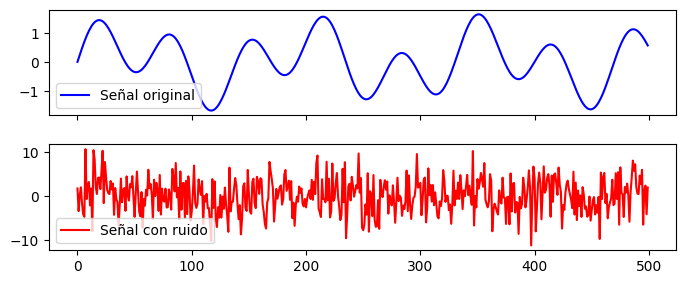

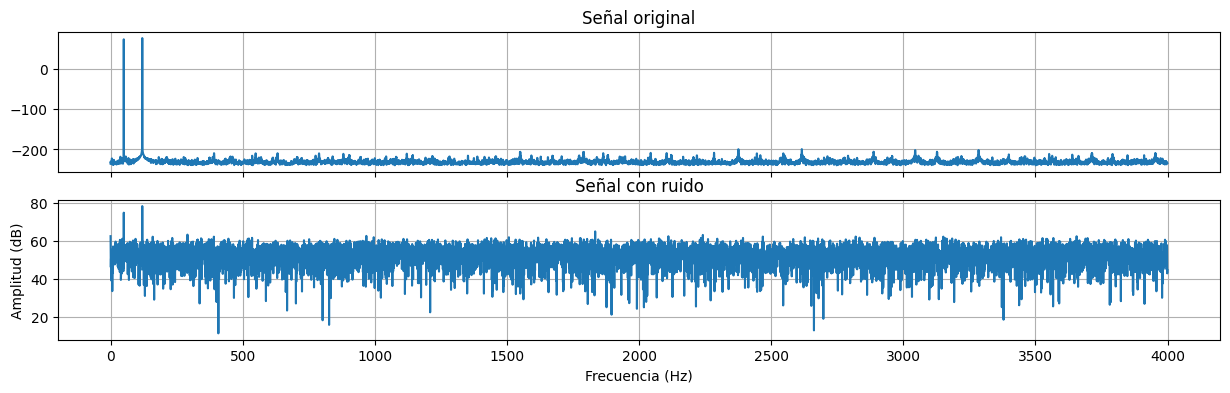

In [21]:
duracion = 2    # Duración (en s) de la señal
fs = 8000       # Frecuencia de muestreo (en Hz)
t = np.linspace(0, duracion, int(duracion * fs), endpoint=False)

# Señales
x = 0.7 * np.sin(2*np.pi*50*t) + np.sin(2*np.pi*120*t)
x_noise = x + np.random.normal(loc=0.0, scale=4.0, size=len(t))

# Visualizar las señales
f, axs = plt.subplots(2, figsize=(7, 3), sharex=True)
plt.tight_layout()
axs[0].plot(x[:500], color = "blue",   label = "Señal original")
axs[0].legend()
axs[1].plot(x_noise[:500], color = "red",   label = "Señal con ruido")
axs[1].legend()


# Espectro de las señales
def plot_spectrum(ax, signal, fs, title):
    n = len(signal)
    fft_result = np.fft.fft(signal)
    freqs = np.fft.fftfreq(n, 1 / fs)

    amplitude = np.abs(fft_result)
    amplitude = 20 * np.log10(amplitude + 1e-12) # Convert amplitude to decibels

    half_n = n // 2
    freqs = freqs[:half_n]
    amplitude = amplitude[:half_n]
    ax.plot(freqs, amplitude)
    ax.set_title(title)
    ax.grid()

signals = [(x, "Señal original"), (x_noise, "Señal con ruido")]
f, axs = plt.subplots(2, figsize=(15, 4), sharex=True)
for i, (a, label) in enumerate(signals):
    plot_spectrum(axs[i], a, fs, label)
axs[i].set_xlabel('Frecuencia (Hz)')
axs[i].set_ylabel('Amplitud (dB)')
plt.show()

# Gráfico Final: Función original, función con ruido, magnitud espectral de la señal original y magnitud espectral de la señal con ruido

<hr style="border: 1px solid green" />

7. **Eliminación del ruido de una señal sinusoidal**

    Generamos una señal aleatoria ruidosa de tipo multiespectral (tres frecuencias: $f1$, $f2$ y $f3$ Hz) de 2 segundos con una frecuencia de muestreo:
    1. $fs = 1234$ Hz y frecuencias $(f1, f2, f3) = (12, 18, 30)$
    2. $fs = 1000$ Hz y frecuencias $(f1, f2, f3) = (50, 120, 160)$
        
    + Selecciona aleatoriamente una de las dos funciones.
    + Obtén su espectro y a partir del mismo reconstruimos la señal.
    + Visualiza la señal original y la señal reconstruida.

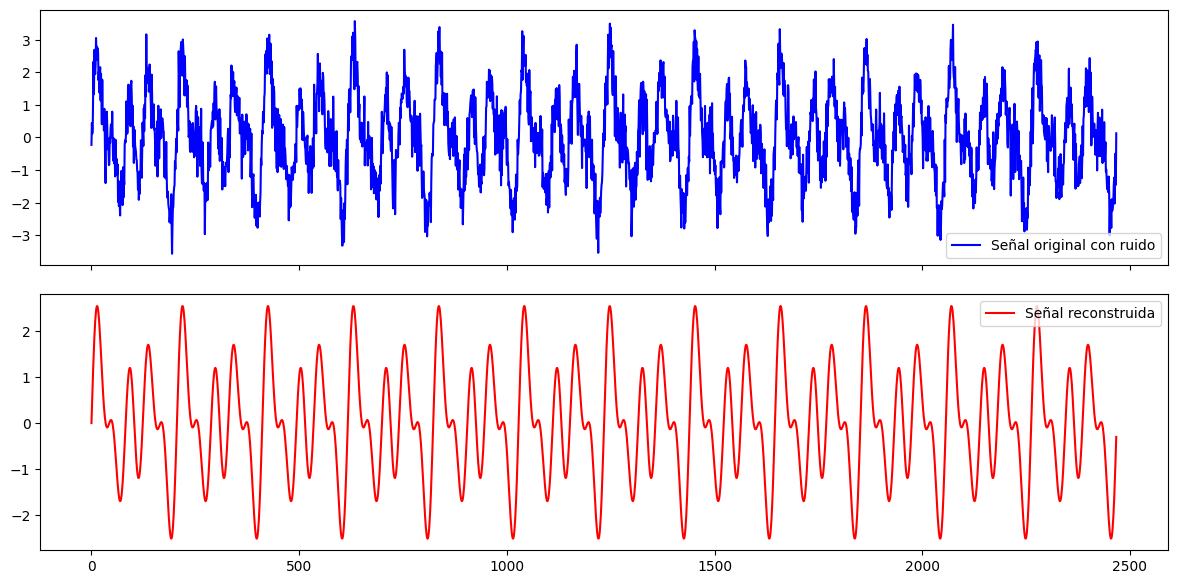

In [34]:
# Función 1
duracion = 2    # Duración (en s) de la señal
fs = 1234       # Frecuencia de muestreo (en Hz)
f1 = 12
f2 = 18
f3 = 30
t = np.linspace(0, duracion, int(duracion * fs), endpoint=False)

# Señale original ruidosa
x = np.sin(2*np.pi*f1*t) + np.sin(2*np.pi*f2*t) + np.sin(2*np.pi*f3*t)
x += np.random.normal(loc=0.0, scale=0.5, size=len(t))


# Reconstrucción de la señal
X = np.fft.fft(x) # Transformada de Fourier

# Magnitud del espectro
magnitude = np.abs(X)

# Filtro basado en magnitud
threshold = 100  # Umbral para la magnitud
X_filtered = np.where(magnitude > threshold, X, 0)
x_filtered = np.fft.ifft(X_filtered).real # Transformada inversa de Fourier

# Visualizar las señales
f, axs = plt.subplots(2, figsize=(12, 6), sharex=True)
plt.tight_layout()
axs[0].plot(x, color = "blue",   label = "Señal original con ruido")
axs[0].legend()
axs[1].plot(x_filtered, color = "red",   label = "Señal reconstruida")
axs[1].legend()


<hr style="border: 1px solid green" />

8. **Eliminación del ruido de una imagen**

    Elimina el ruido de una imagen RGB (`images_RGB_channels/dog.jpg`) a partir del espectro de la misma.
    + Pasamos a escala de grises y le añadimos ruido a la imagen.
    + Obtenemos su espectro y a partir del mismo reconstruimos la imagen.
    + Visualiza la imagen original con ruido y la imagen reconstruida.

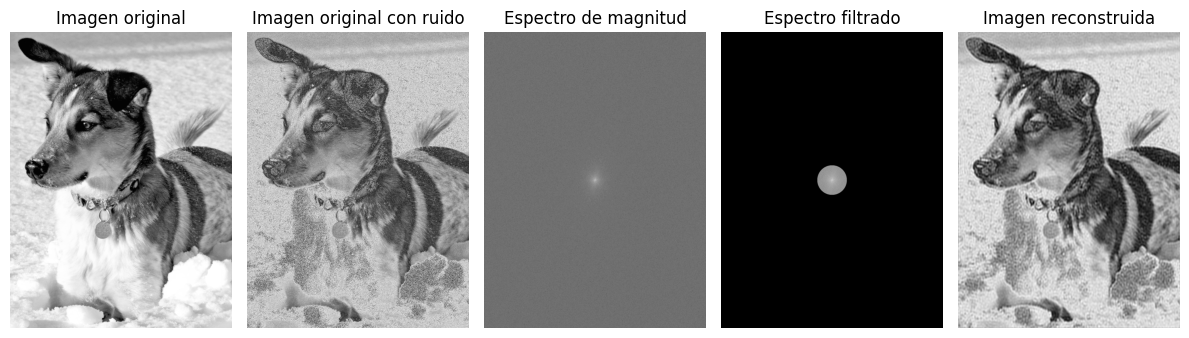

In [41]:
image_path = "images_RGB_channels/dog.jpg"

img = cv2.imread(image_path)  # Cargar la imagen
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convertir a escala de grises
noisy_img = gray_img + np.random.normal(0, 25, gray_img.shape).astype(np.uint8)  # Ruido gaussiano

# Transformada de Fourier 2D
dft = cv2.dft(np.float32(noisy_img), flags=cv2.DFT_COMPLEX_OUTPUT)
dft_shift = np.fft.fftshift(dft)  # Desplazar la DC al centro
magnitude_spectrum = 20 * np.log(cv2.magnitude(dft_shift[:, :, 0], dft_shift[:, :, 1]) + 1)

# Filtrar el espectro (eliminar componentes de alta frecuencia)
rows, cols = gray_img.shape
crow, ccol = rows // 2, cols // 2  # Centro del espectro
mask = np.zeros((rows, cols, 2), np.uint8)
r = 100  # Radio de la máscara
y, x = np.ogrid[:rows, :cols]
mask_area = (x - ccol)**2 + (y - crow)**2 <= r**2
mask[mask_area] = 1

# Aplicar la máscara al espectro
filtered_dft = dft_shift * mask

# Transformada Inversa de Fourier
filtered_dft_ishift = np.fft.ifftshift(filtered_dft)  # Revertir el desplazamiento
reconstructed_img = cv2.idft(filtered_dft_ishift)
reconstructed_img = cv2.magnitude(reconstructed_img[:, :, 0], reconstructed_img[:, :, 1])
reconstructed_img = cv2.normalize(reconstructed_img, None, 0, 255, cv2.NORM_MINMAX)

# Visualizar las imágenes
# Imagen original
plt.figure(figsize=(12, 8))
plt.subplot(1, 5, 1)
plt.title("Imagen original")
plt.imshow(gray_img, cmap='gray')
plt.axis('off')

# Imagen original con ruido
plt.subplot(1, 5, 2)
plt.title("Imagen original con ruido")
plt.imshow(noisy_img, cmap='gray')
plt.axis('off')

# Espectro de magnitud
plt.subplot(1, 5, 3)
plt.title("Espectro de magnitud")
plt.imshow(magnitude_spectrum, cmap='gray')
plt.axis('off')

# Máscara aplicada al espectro
plt.subplot(1, 5, 4)
plt.title("Espectro filtrado")
plt.imshow(20 * np.log(cv2.magnitude(filtered_dft[:, :, 0], filtered_dft[:, :, 1]) + 1), cmap='gray')
plt.axis('off')

# Imagen reconstruida
plt.subplot(1, 5, 5)
plt.title("Imagen reconstruida")
plt.imshow(reconstructed_img, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

---

# **Ventanas**

9. Genera una ventana y utilízala para obtener el espectro de una señal sinusoidal. Visualiza la ventana, la señal, la magnitud espectral de ambas señales y la magnitud espectral en decibelios.

    $$x(t) = Acos(2\pi f \cdot t + \phi)$$

    Ten en cuenta los datos siguientes: 
    * Tipo de ventana: El tipo de ventana que desees
    * Tamaño de la ventana: El tamaño de ventana que desees
    * Frecuencia de muestreo : $fs=128$
    * Amplitud y fase de la sinusoide: $A=1$ y $\phi=0$
    * Frecuencia base: La frecuencia que desees ($f$)

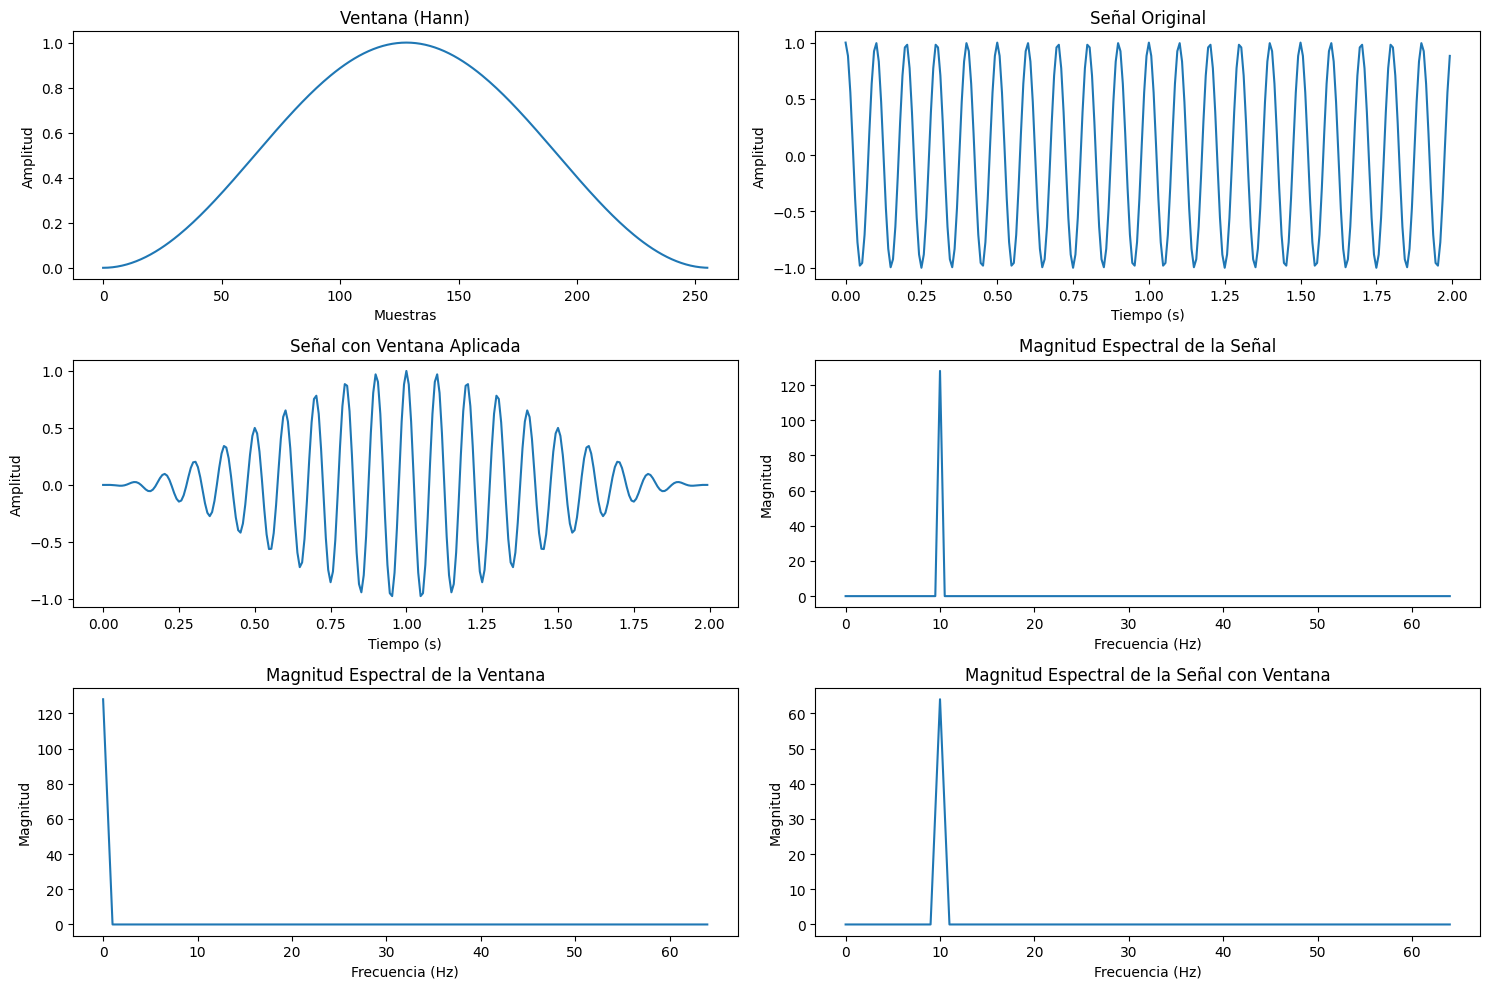

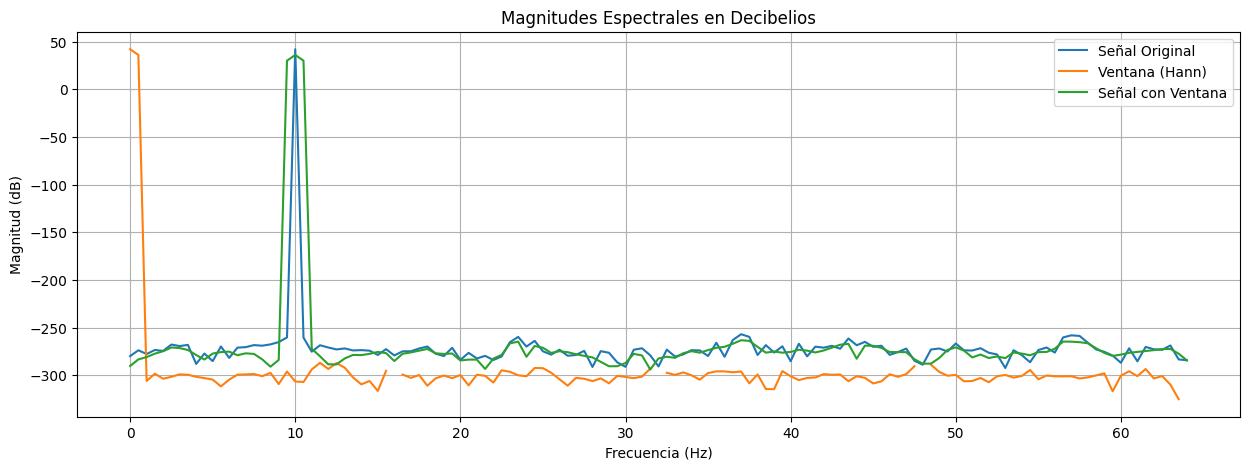

In [5]:
# Parámetros
duracion = 2                        # Duración (en s) de la señal
fs = 128                            # Frecuencia de muestreo (en Hz)
A = 1                               # Amplitud
phase = 0                           # Fase
f_base = 10                         # Frecuencia base (en Hz)
window_type = 'hann'                # Tipo de ventana
window_size = int(duracion * fs)    # Tamaño de ventana

t = np.linspace(0, duracion, int(duracion * fs), endpoint=False)
x = A * np.cos(2 * np.pi * f_base * t + phase)

# Generar la ventana
window = get_window(window_type, window_size)

# Aplicar la ventana a la señal
x_windowed = x * window

# Calcular las magnitudes espectrales
frequencies = np.fft.rfftfreq(window_size, 1 / fs)

spectrum_signal             = np.abs(np.fft.rfft(x))
spectrum_signal_db          = 20 * np.log10(spectrum_signal)

spectrum_window             = np.abs(np.fft.rfft(window))
spectrum_window_db          = 20 * np.log10(spectrum_window)

spectrum_windowed_signal    = np.abs(np.fft.rfft(x_windowed))
spectrum_windowed_signal_db = 20 * np.log10(spectrum_windowed_signal)

# Visualización
plt.figure(figsize=(15, 10))

# Ventana
plt.subplot(3, 2, 1)
plt.plot(window)
plt.title('Ventana (Hann)')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')

# Señal original
plt.subplot(3, 2, 2)
plt.plot(t, x)
plt.title('Señal Original')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')

# Señal con ventana
plt.subplot(3, 2, 3)
plt.plot(t, x_windowed)
plt.title('Señal con Ventana Aplicada')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')

# Magnitud espectral de la señal
plt.subplot(3, 2, 4)
plt.plot(frequencies, spectrum_signal)
plt.title('Magnitud Espectral de la Señal')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Magnitud')

# Magnitud espectral de la ventana
plt.subplot(3, 2, 5)
plt.plot(frequencies, spectrum_window)
plt.title('Magnitud Espectral de la Ventana')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Magnitud')

# Magnitud espectral de la señal con ventana
plt.subplot(3, 2, 6)
plt.plot(frequencies, spectrum_windowed_signal)
plt.title('Magnitud Espectral de la Señal con Ventana')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Magnitud')

plt.tight_layout()
plt.show()

# Visualización en decibelios
plt.figure(figsize=(15, 5))
plt.plot(frequencies, spectrum_signal_db, label='Señal Original')
plt.plot(frequencies, spectrum_window_db, label='Ventana (Hann)')
plt.plot(frequencies, spectrum_windowed_signal_db, label='Señal con Ventana')
plt.title('Magnitudes Espectrales en Decibelios')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Magnitud (dB)')
plt.legend()
plt.grid()
plt.show()


---

# **Efectos de audio**

10. Visualiza los espectros de los efectos de audio de:
   
  


In [ ]:
# Lee los audios (reverberación, flanger, chorus, phaser) de uno de los dos instrumentos: guitarra o percusión
# Visualiza el oscilograma y el espectrograma de todos los audios
# Oye todos los audios

defaultdict(<class 'list'>, {'chorus': ['./audio_effects/chorus_guitarra1.mp3', './audio_effects/chorus_guitarra2.mp3'], 'flanger': ['./audio_effects/flanger_guitarra1.mp3', './audio_effects/flanger_guitarra2.mp3'], 'phaser': ['./audio_effects/phaser_guitarra1.mp3', './audio_effects/phaser_guitarra2.mp3'], 'reverb': ['./audio_effects/reverb_guitarra1.mp3', './audio_effects/reverb_guitarra2.mp3']})


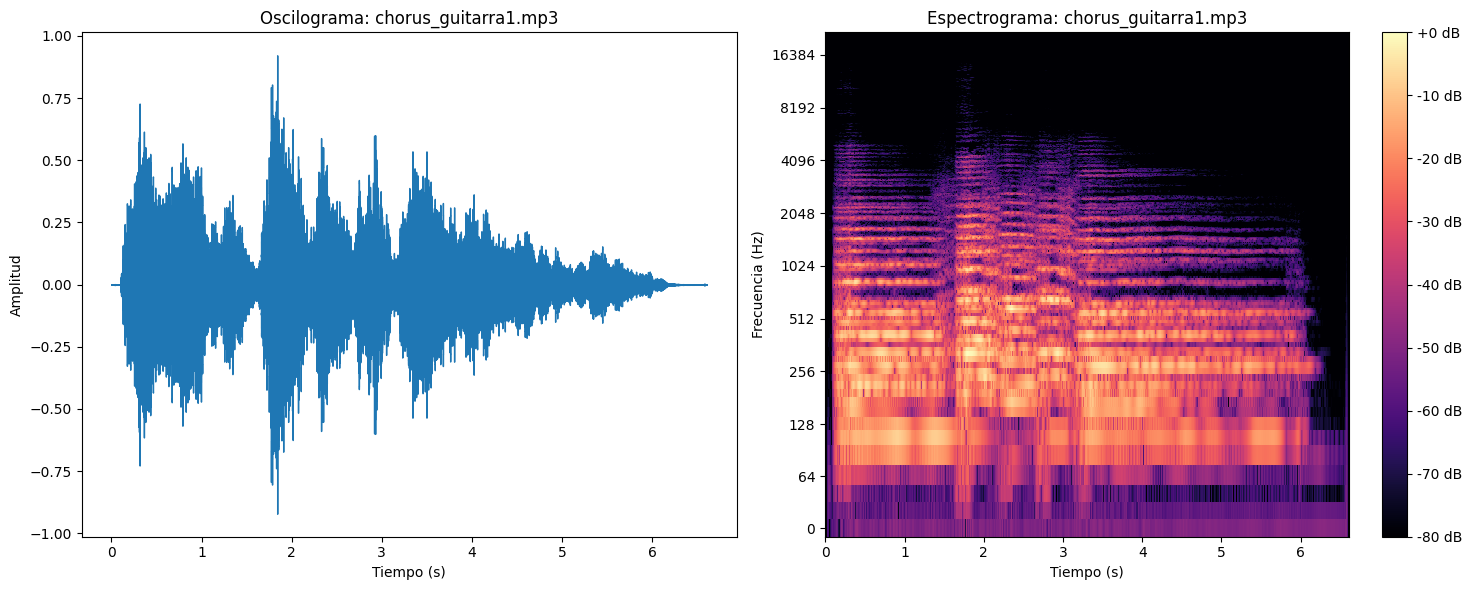

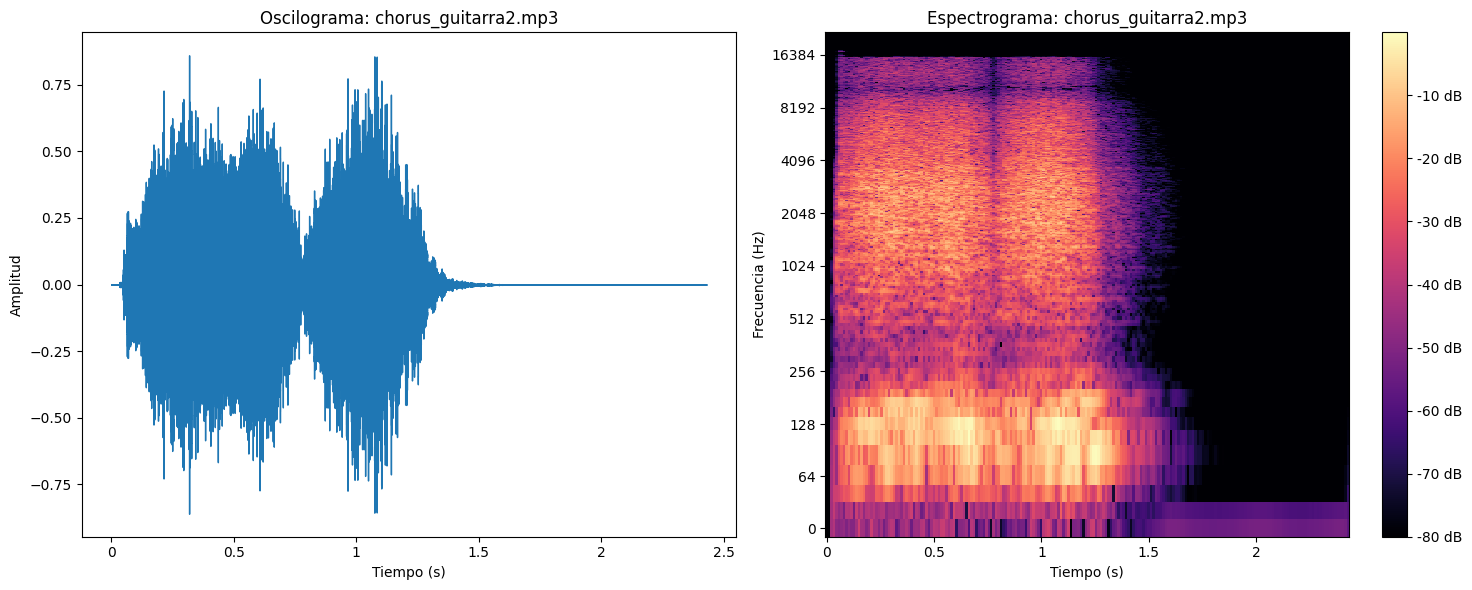

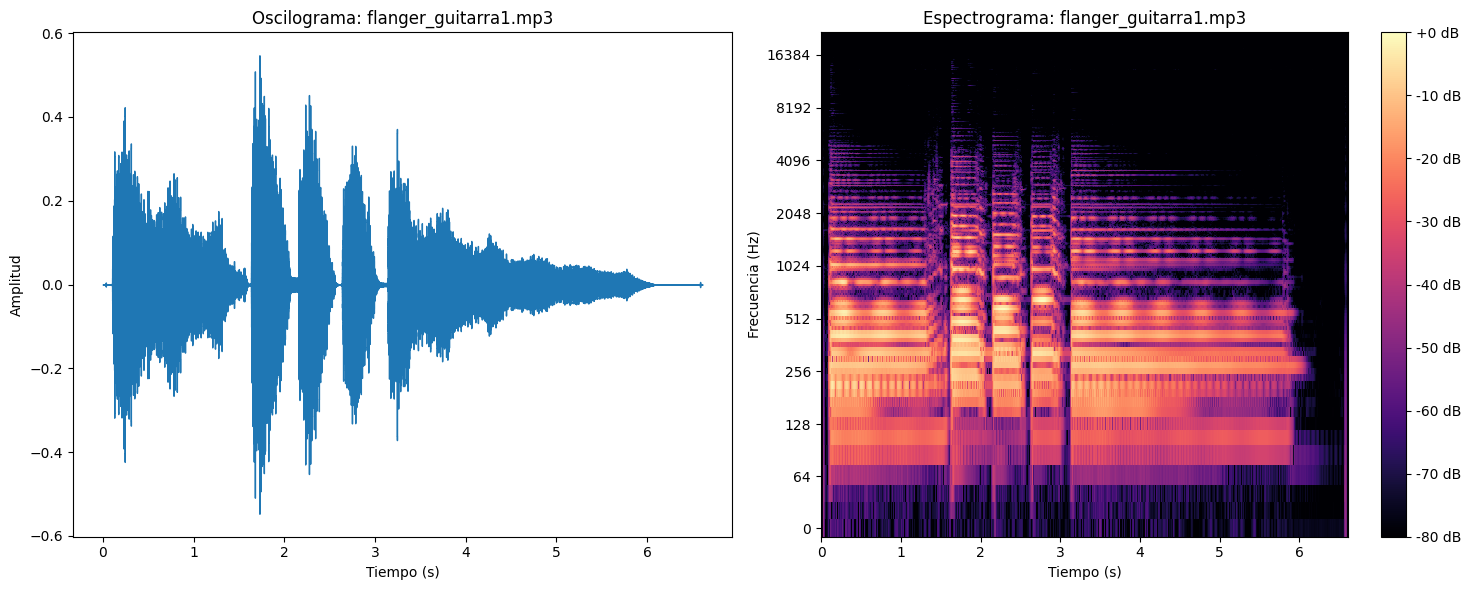

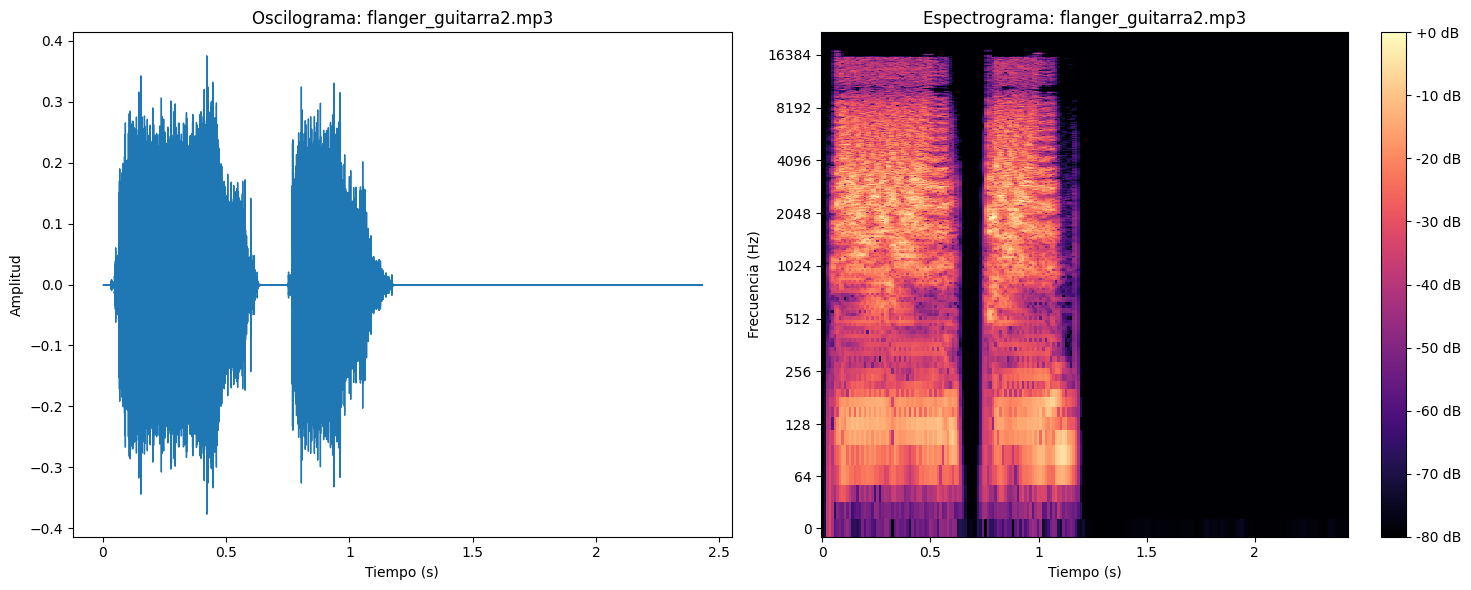

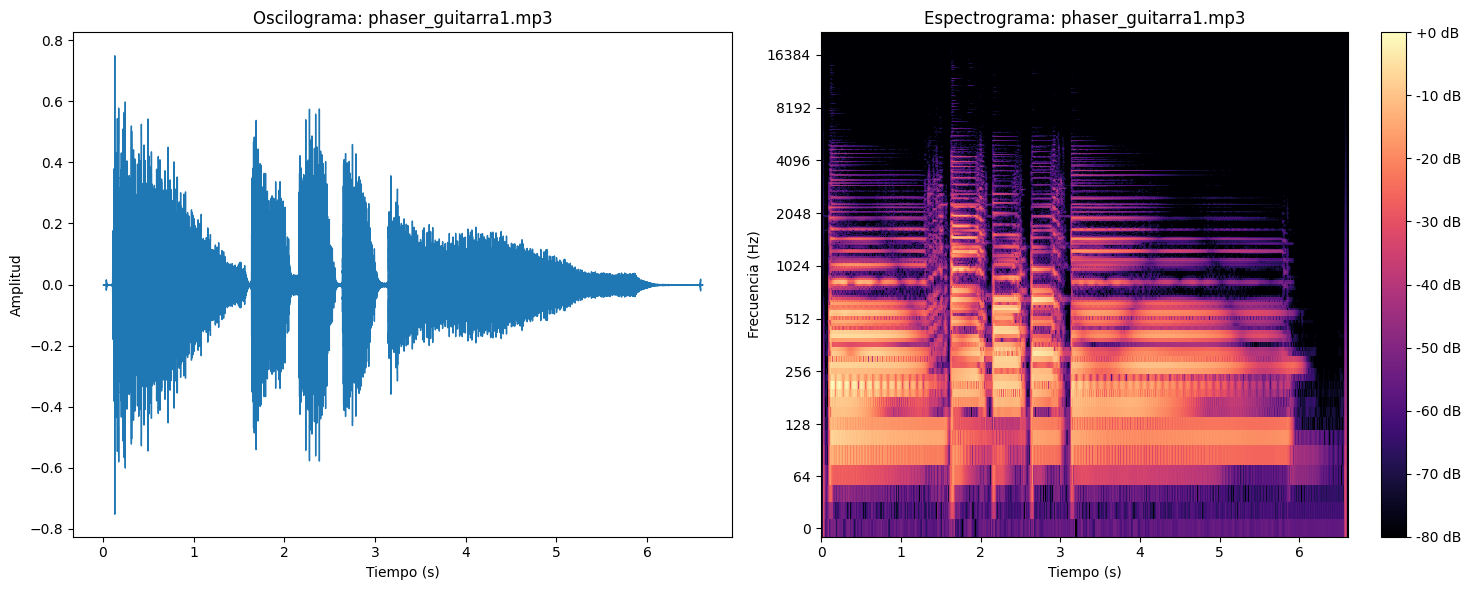

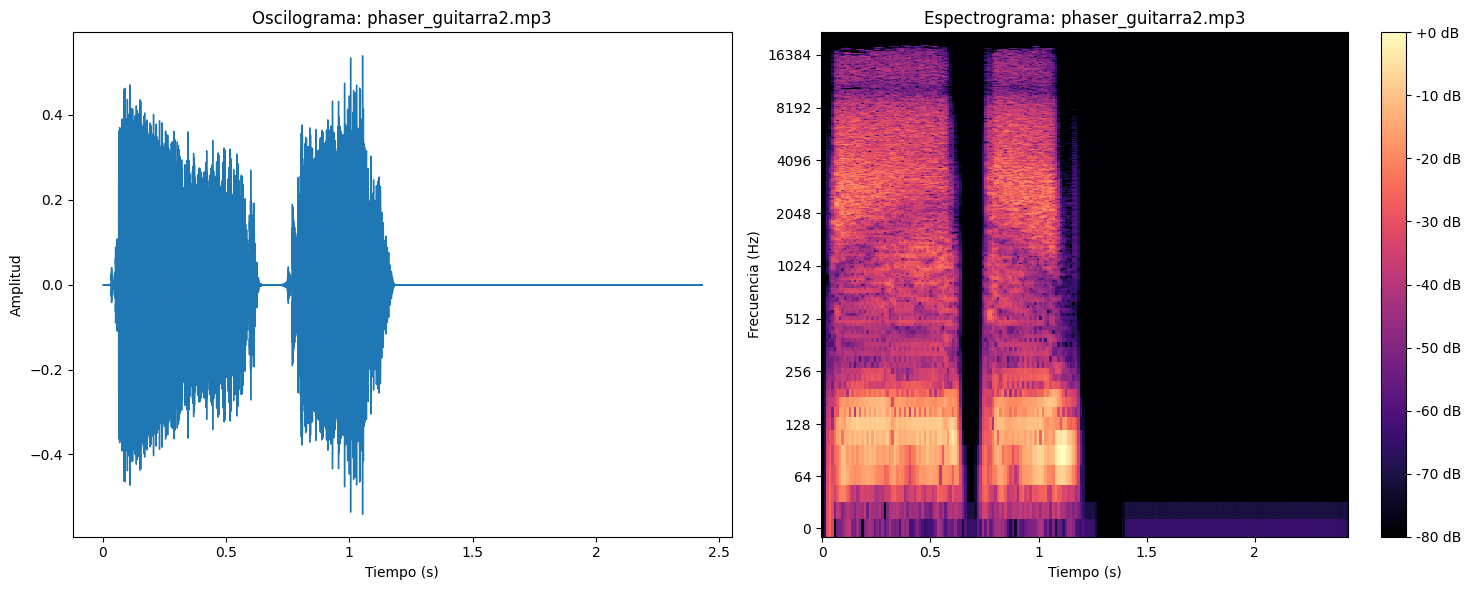

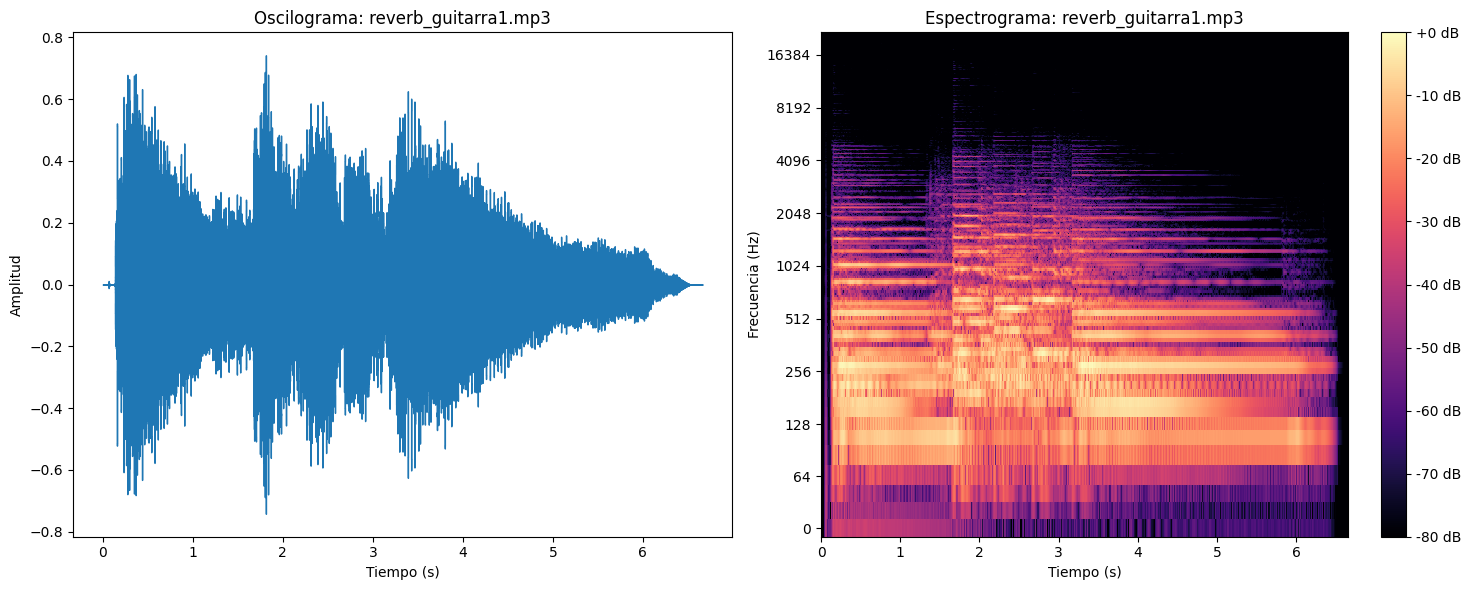

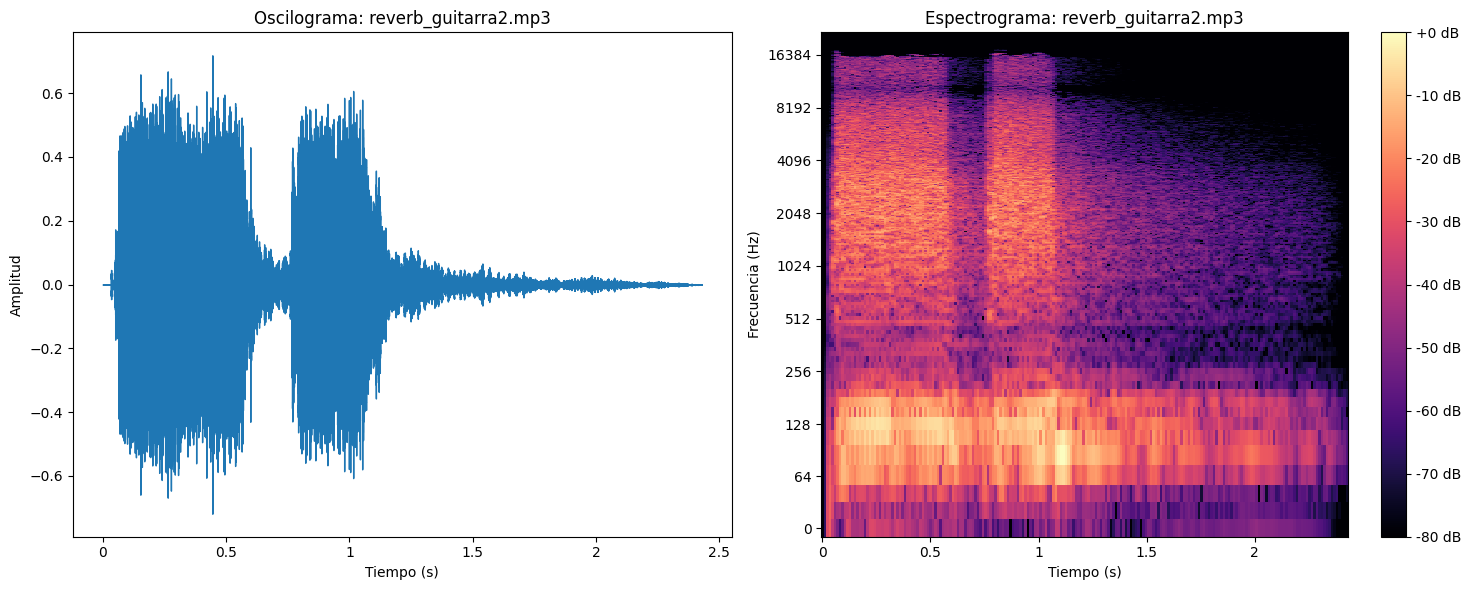

In [31]:
from collections import defaultdict

instrumentos = ["guitarra1", "guitarra2"] # ["guitarra1", "guitarra2", "percusion1", "percusion2"]
types = ["reverb", "flanger", "chorus", "phaser"]

def get_inst_paths(instrumentos: list, types: list, audio_path:str = "./audio_effects/"):
    selected_paths = defaultdict(list)
    all_paths = os.listdir(audio_path)
    all_paths.sort()

    for inst in instrumentos:
        for path in all_paths:
            if path.find(inst) != -1:
                audio_type = os.path.basename(path).split('_')[0]
                if not audio_type in types:
                    continue
                path = os.path.join(audio_path, path)
                selected_paths[audio_type].append(path)

    return selected_paths

def visualize_audio_paths(audio_paths):
    for effect_type, paths in audio_paths.items():
        for path in paths:
            # Cargar el audio
            y, sr = librosa.load(path, sr=None)

            # Visualización
            plt.figure(figsize=(15, 6))

            # Oscilograma
            plt.subplot(1, 2, 1)
            librosa.display.waveshow(y, sr=sr)
            plt.title(f'Oscilograma: {os.path.basename(path)}')
            plt.xlabel('Tiempo (s)')
            plt.ylabel('Amplitud')

            # Espectrograma
            plt.subplot(1, 2, 2)
            S = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
            librosa.display.specshow(S, sr=sr, x_axis='time', y_axis='log', cmap='magma')
            plt.title(f'Espectrograma: {os.path.basename(path)}')
            plt.colorbar(format='%+2.0f dB')
            plt.xlabel('Tiempo (s)')
            plt.ylabel('Frecuencia (Hz)')

            plt.tight_layout()
            plt.show()



audio_paths = get_inst_paths(instrumentos, types)
print(audio_paths)
visualize_audio_paths(audio_paths)


---

# **Referencias**

**@Dixon2001** Dixon, S. (2001). Learning to detect onsets of acoustic piano tones. Proceedings of the Workshop on Current Directions in Computer Music Research

**@Klapuri1999** Klapuri, A. P. (1999). Sound onset detection by applying psychoacoustic knowledge. Proceedings of the IEEE International Conference on Acoustics, Speech and Signal Processing

**@Klapuri2006** Klapuri, A. and Davy, M. (2006). Signal Processing Methods for Music Transcription. Springer, 1st edition

[**Mathematics of the DFT with audio applications**](http://www.dsprelated.com/freebooks/mdft/)

[**Spectral Audio Signal Processing**](http://www.dsprelated.com/freebooks/sasp/)

[**Demos**](http://pages.jh.edu/~signals/)